In [1]:
# the data is obtained from the State of Iowa's data portal: https://data.iowa.gov/Public-Safety/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4
# in this notebook, I use machine learning algorithms to predict prisoner recidivism in Iowa
# the prediction problem is a binary classification problem (prisoners either return to prison, or don't)

In [2]:
# clear all variables, functions, etc
%reset -f

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np #foundational package for scientific computing
import matplotlib as mpl #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt
from IPython import display #pretty printing of dataframes in Jupyter notebook
import seaborn as sns #data visualization

print('All libraries loaded successfully')

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Fixing random state for reproducibility
np.random.seed(123)

All libraries loaded successfully


In [3]:
# import dataset
full = pd.read_csv('../data/Iowa recidivism/3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv')

In [4]:
# rename select variables
full = full.rename(index = str, columns = {'Race - Ethnicity':'race',
                                           'Sex':'sex',
                                           'Age At Release ':'age',
                                           'Convicting Offense Classification':'offence_class',
                                           'Convicting Offense Type':'offence_type',
                                           'Release Type':'release_type',
                                           'Recidivism - Return to Prison':'recidivism',
                                           'Part of Target Population':'targeted'})

# keep select variables
full = full[['race','sex','age','offence_class','offence_type','release_type','targeted','recidivism']]

In [5]:
# check for missing values
full.isnull().sum()

# impute missing values with column mode
for i in list(full):
    full[i] = full[i].fillna(full[i].mode()[0])

0    0.675367
1    0.324633
Name: recidivism, dtype: float64


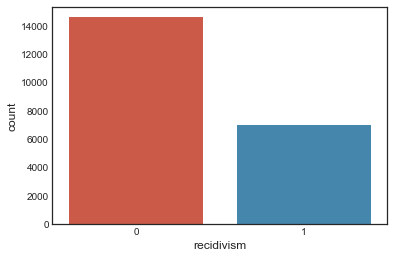

In [6]:
# recode target variable
full.loc[(full['recidivism']=='Yes'),'recidivism'] = '1'
full.loc[(full['recidivism']=='No'),'recidivism'] = '0'
# convert target variable from string to int datatype
full['recidivism'] = full['recidivism'].astype('int')

# view the frequencies of the values in 'recidivism'
sns.countplot(x='recidivism', data=full)

print(full['recidivism'].value_counts()/full.shape[0])
# about 67% of prisoners don't come back; a baseline model that always predicts no recidivism will hence achieve 67% accuracy
# we want to build a machine learning model that can do better than this baseline model

In [7]:
# recode minor categories of the categorical features, as well as categories that mean the same thing
full.loc[(full['race'] != 'White - Non-Hispanic') &
         (full['race'] != 'Black - Non-Hispanic') &
         (full['race'] != 'White - Hispanic'),'race'] = 'Others'

full.loc[(full['offence_class'] != 'D Felony') &
         (full['offence_class'] != 'C Felony') &
         (full['offence_class'] != 'Aggravated Misdemeanor') &
         (full['offence_class'] != 'B Felony') &
         (full['offence_class'] != 'Felony - Enhancement to Original Penalty'),'offence_class'] = 'Others'

full.loc[(full['release_type']=='Parole Granted'),'release_type'] = 'Parole'

full['discharged'] = full['release_type'].apply(lambda x: x[0:10]=='Discharged')
full.loc[(full['discharged']==True),'release_type'] = 'Discharged'
del full['discharged']

full.loc[(full['release_type']!='Parole') &
         (full['release_type']!='Discharged'),'release_type'] = 'Others'

# check that the recoding was performed correctly
for x in list(full):
    print(full[x].value_counts())
    print('-'*50)

White - Non-Hispanic    14616
Black - Non-Hispanic     5106
White - Hispanic         1284
Others                    640
Name: race, dtype: int64
--------------------------------------------------
M    18928
F     2718
Name: sex, dtype: int64
--------------------------------------------------
25-34           7922
35-44           5174
Under 25        3845
45-54           3639
55 and Older    1066
Name: age, dtype: int64
--------------------------------------------------
D Felony                                    8773
C Felony                                    5664
Aggravated Misdemeanor                      4076
B Felony                                    1494
Felony - Enhancement to Original Penalty    1200
Others                                       439
Name: offence_class, dtype: int64
--------------------------------------------------
Drug            6603
Property        6091
Violent         4854
Public Order    3097
Other           1001
Name: offence_type, dtype: int64
----------

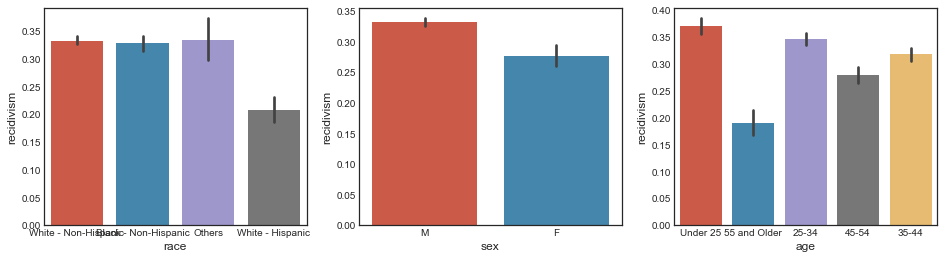

In [8]:
# plot some possibly useful graphs
fig, saxis = plt.subplots(1, 3,figsize=(16,4)) # to fit 1 rows and 3 columns worth of subplots in one plot

sns.barplot(x = 'race', y = 'recidivism', data=full, ax = saxis[0])
sns.barplot(x = 'sex', y = 'recidivism', data=full, ax = saxis[1])
sns.barplot(x = 'age', y = 'recidivism', data=full, ax = saxis[2])

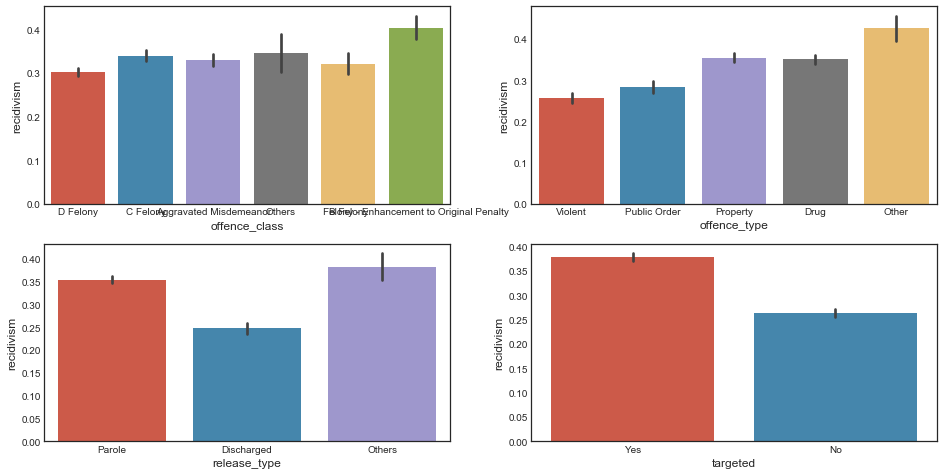

In [9]:
# plot some possibly useful graphs (continued)
fig, saxis = plt.subplots(2, 2,figsize=(16,8)) # to fit 2 rows and 2 columns worth of subplots in one plot

sns.barplot(x = 'offence_class', y = 'recidivism', data=full, ax = saxis[0][0])
sns.barplot(x = 'offence_type', y = 'recidivism', data=full, ax = saxis[0][1])
sns.barplot(x = 'release_type', y = 'recidivism', data=full, ax = saxis[1][0])
sns.barplot(x = 'targeted', y = 'recidivism', data=full, ax = saxis[1][1])

In [10]:
# dummify all categorical variables
full = pd.get_dummies(full)

In [11]:
# split the cleaned full dataset into train and test datasets
from sklearn import model_selection
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(full.drop(['recidivism'], axis=1), full['recidivism'], test_size=0.2, shuffle=True)

the mean training accuracy is: 0.6808282701554738
the mean validation accuracy is: 0.6771194382878136
Correct      0.675982
Incorrect    0.324018
Name: correct, dtype: float64


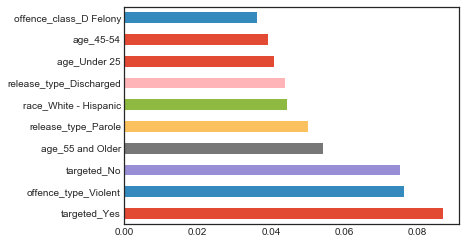

In [12]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# initialize a template for random forest, based on the parameters you want to set
my_rfc = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                                n_estimators = 200, # number of trees
                                max_features = "sqrt", # number of features to consider at each split
                                max_depth = 8) # maximum tree depth

# 10-fold CV
cv_results = model_selection.cross_validate(my_rfc,
                                            xtrain,
                                            ytrain,
                                            scoring = 'accuracy',
                                            cv = 10)

print("the mean training accuracy is:", cv_results['train_score'].mean())
print("the mean validation accuracy is:", cv_results['test_score'].mean())

# fit the random forest
rf1 = my_rfc.fit(xtrain,ytrain)

# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rf1.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# use the fitted model to make predictions, then check the accuracy of the test predictions
predictions_rf = rf1.predict(xtest)
predictions_rf = predictions_rf.astype('int')
predictions_rf = pd.DataFrame({'pred':predictions_rf})
predictions_rf.reset_index(drop=True, inplace=True)

ytest = pd.DataFrame({'recidivism':ytest})
ytest.reset_index(drop=True, inplace=True)

ytest_predictions_rf = pd.concat([predictions_rf,ytest],axis='columns')
ytest_predictions_rf['correct'] = 'Incorrect'
ytest_predictions_rf.loc[(ytest_predictions_rf['pred']==ytest_predictions_rf['recidivism']),'correct'] = 'Correct'
print(ytest_predictions_rf['correct'].value_counts()/ytest_predictions_rf.shape[0])

In [13]:
# the random forest has the same accuracy as the baseline; this suggests that the random forest is simply ignoring the minority class
ytest_predictions_rf['pred'].value_counts() # the random forest is indeed underpredicting the minority class

0    4274
1      56
Name: pred, dtype: int64

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(ytest_predictions_rf['recidivism'], ytest_predictions_rf['pred']))
print('-'*50)

cm = confusion_matrix(ytest_predictions_rf['recidivism'], ytest_predictions_rf['pred'])
cm[0] = cm[0]/cm[0].sum()*100
cm[1] = cm[1]/cm[1].sum()*100
print(cm)
# proportion of non-recidivists who are correctly identified as such: 99% (this is the true negative rate / specificity)
# proportion of recidivists who are correctly identified as such: 2% (this is true positive rate / sensitivity / recall)

[[2898   27]
 [1376   29]]
--------------------------------------------------
[[99  0]
 [97  2]]


the mean training accuracy is: 0.6060098198052899
the mean validation accuracy is: 0.5839102126155543
Correct      0.583372
Incorrect    0.416628
Name: correct, dtype: float64


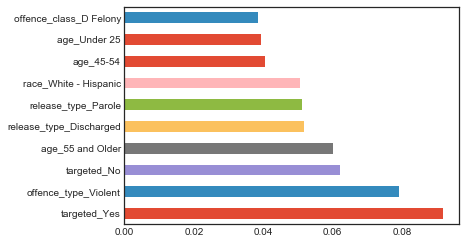

In [15]:
# random forest, but we assign higher weights to the minority class, so as to prevent the forest from being biased towards the majority class
from sklearn.ensemble import RandomForestClassifier

# initialize a template for random forest, based on the parameters you want to set
my_rfc = RandomForestClassifier(n_jobs = -1, # fully utilize the cores on your computer
                                n_estimators = 200, # number of trees
                                max_features = "sqrt", # number of features to consider at each split
                                class_weight = 'balanced',
                                max_depth = 8) # maximum tree depth

# 10-fold CV
cv_results = model_selection.cross_validate(my_rfc,
                                            xtrain,
                                            ytrain,
                                            scoring = 'accuracy',
                                            cv = 10)

print("the mean training accuracy is:", cv_results['train_score'].mean())
print("the mean validation accuracy is:", cv_results['test_score'].mean())

# fit the random forest
rf1 = my_rfc.fit(xtrain,ytrain)

# plot feature importance (as determined by the built random forest model)
feature_importances = pd.Series(rf1.feature_importances_, index=xtrain.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# use the fitted model to make predictions, then check the accuracy of the test predictions
predictions_rf = rf1.predict(xtest)
predictions_rf = predictions_rf.astype('int')
predictions_rf = pd.DataFrame({'pred':predictions_rf})
predictions_rf.reset_index(drop=True, inplace=True)

ytest_predictions_rf = pd.concat([predictions_rf,ytest],axis='columns')
ytest_predictions_rf['correct'] = 'Incorrect'
ytest_predictions_rf.loc[(ytest_predictions_rf['pred']==ytest_predictions_rf['recidivism']),'correct'] = 'Correct'
print(ytest_predictions_rf['correct'].value_counts()/ytest_predictions_rf.shape[0])
# random forest with class balancing has lower accuracy than the basic random forest, but sensitivity may be better

In [16]:
# first, let's check if the random forest is still underpredicting the minority class (shouldn't be the case)
print(ytest_predictions_rf['pred'].value_counts()) # random forest is not underpredicting the minority class

1    2215
0    2115
Name: pred, dtype: int64


In [17]:
# next, let's check the confusion matrix; bottom-right value reflects sensitivity
from sklearn.metrics import confusion_matrix

print(confusion_matrix(ytest_predictions_rf['recidivism'], ytest_predictions_rf['pred']))
print('-'*50)

cm = confusion_matrix(ytest_predictions_rf['recidivism'], ytest_predictions_rf['pred'])
cm[0] = cm[0]/cm[0].sum()*100
cm[1] = cm[1]/cm[1].sum()*100
print(cm)
# proportion of non-recidivists who are correctly identified as such: 55% (this is the true negative rate / specificity)
# proportion of recidivists who are correctly identified as such: 64% (this is true positive rate / sensitivity / recall)

[[1618 1307]
 [ 497  908]]
--------------------------------------------------
[[55 44]
 [35 64]]
